In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
CSV_PATH = r"F:\MultiDimensionalAD\data\long_run_labelled.csv"

DROP_COLS = ["Seconds", "Timestamp_IST", "State", "label"]
SENSOR_TAGS = ("PI", "PT", "TI", "TT")

WARMUP = 50
N_COMPONENTS = 2


In [3]:
df = pd.read_csv(CSV_PATH)
df = df.drop(columns=[c for c in DROP_COLS if c in df.columns])

sensor_cols = [c for c in df.columns if any(tag in c for tag in SENSOR_TAGS)]
X = df[sensor_cols].values.astype(np.float64)

n_samples, n_features = X.shape
t = np.arange(n_samples)


In [4]:
class OjaPCA:
    def __init__(self, n_components, lr=0.005):
        self.k = n_components
        self.lr = lr
        self.W = None

    def partial_fit(self, x):
        if self.W is None:
            self.W = np.random.randn(self.k, x.shape[0])
            self.W /= np.linalg.norm(self.W, axis=1, keepdims=True)

        for i in range(self.k):
            y = self.W[i] @ x
            self.W[i] += self.lr * y * (x - y * self.W[i])
            self.W[i] /= np.linalg.norm(self.W[i])

            # deflation
            x = x - y * self.W[i]

    def transform(self, x):
        return np.array([w @ x for w in self.W])


In [5]:
scaler = StandardScaler()
scaler.partial_fit(X[:WARMUP])

oja = OjaPCA(N_COMPONENTS, lr=0.003)
Z_oja = np.zeros((n_samples, N_COMPONENTS))

for i in range(WARMUP):
    oja.partial_fit(scaler.transform(X[i:i+1])[0])

for t_idx in range(WARMUP, n_samples):
    x = X[t_idx:t_idx+1]
    xs = scaler.transform(x)[0]

    Z_oja[t_idx] = oja.transform(xs)

    scaler.partial_fit(x)
    oja.partial_fit(xs)


In [6]:
class CCIPCA:
    def __init__(self, n_components, lr=0.01):
        self.k = n_components
        self.lr = lr
        self.V = None

    def partial_fit(self, x):
        if self.V is None:
            self.V = np.random.randn(self.k, x.shape[0])

        for i in range(self.k):
            proj = self.V[i] @ x
            self.V[i] = (1 - self.lr) * self.V[i] + self.lr * proj * x
            self.V[i] /= np.linalg.norm(self.V[i])

            x = x - proj * self.V[i]

    def transform(self, x):
        return np.array([v @ x for v in self.V])


In [7]:
scaler = StandardScaler()
scaler.partial_fit(X[:WARMUP])

ccipca = CCIPCA(N_COMPONENTS, lr=0.01)
Z_ccipca = np.zeros((n_samples, N_COMPONENTS))

for i in range(WARMUP):
    ccipca.partial_fit(scaler.transform(X[i:i+1])[0])

for t_idx in range(WARMUP, n_samples):
    x = X[t_idx:t_idx+1]
    xs = scaler.transform(x)[0]

    Z_ccipca[t_idx] = ccipca.transform(xs)

    scaler.partial_fit(x)
    ccipca.partial_fit(xs)


In [8]:
WINDOW = 300
Z_window = np.zeros((n_samples, N_COMPONENTS))

scaler = StandardScaler()

for t_idx in range(WARMUP, n_samples):
    start = max(0, t_idx - WINDOW)
    X_win = X[start:t_idx]

    Xs = scaler.fit_transform(X_win)
    pca = PCA(N_COMPONENTS)
    pca.fit(Xs)

    Z_window[t_idx] = pca.transform(
        scaler.transform(X[t_idx:t_idx+1])
    )[0]


In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ---- OFFLINE PCA (GROUND TRUTH) ----
scaler_off = StandardScaler()
X_scaled_off = scaler_off.fit_transform(X)

pca_off = PCA(n_components=2)
Z_offline = pca_off.fit_transform(X_scaled_off)


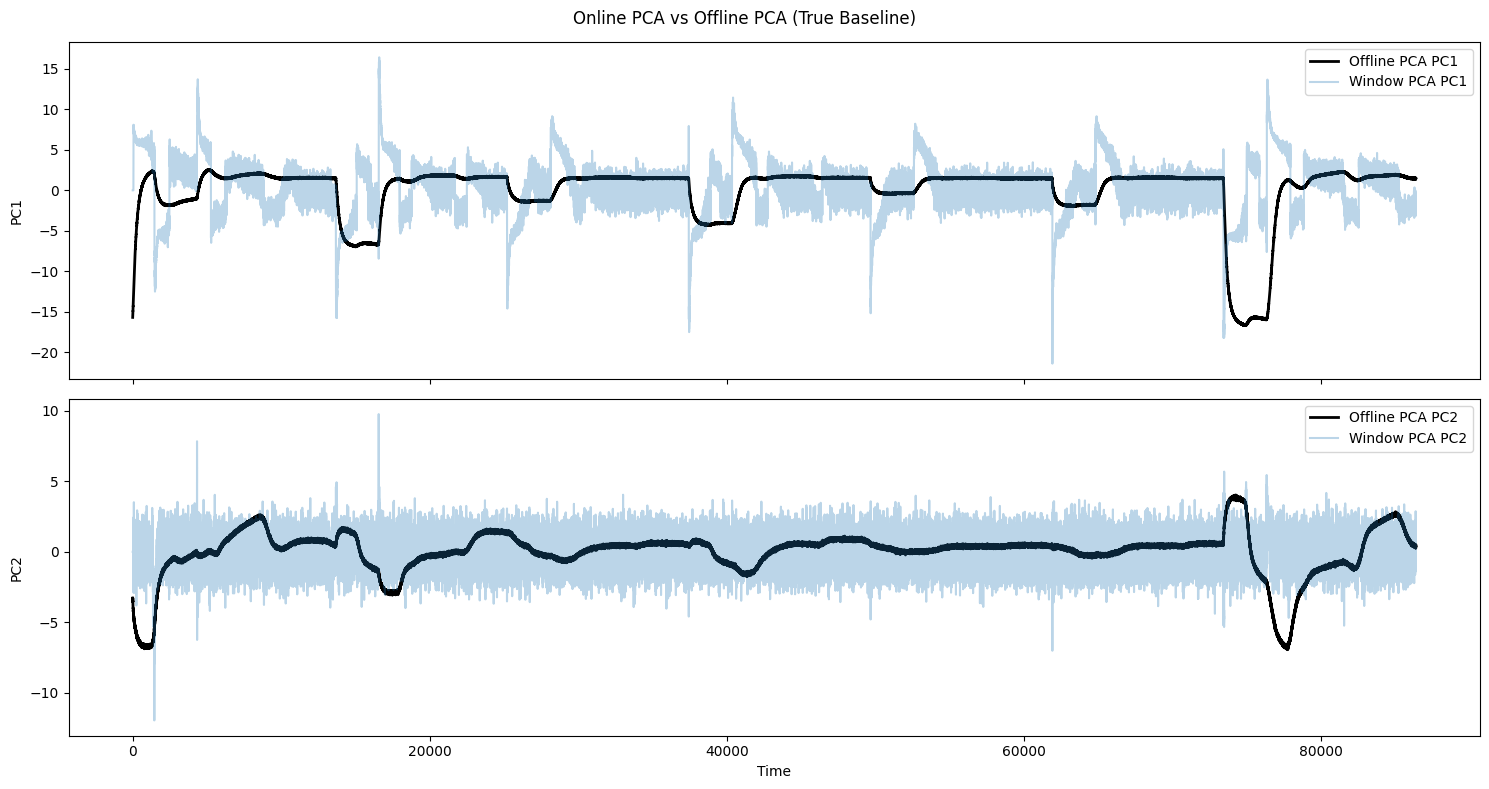

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# -------- PC1 --------
axes[0].plot(t, Z_offline[:, 0], label="Offline PCA PC1", color="black", linewidth=2)
# axes[0].plot(t, Z_oja[:, 0], label="Oja PC1", alpha=0.5)
# axes[0].plot(t, Z_ccipca[:, 0], label="CCIPCA PC1", alpha=0.7)
axes[0].plot(t, Z_window[:, 0], label="Window PCA PC1", alpha=0.3)

axes[0].set_ylabel("PC1")
axes[0].legend(loc="upper right")

# -------- PC2 --------
axes[1].plot(t, Z_offline[:, 1], label="Offline PCA PC2", color="black", linewidth=2)
# axes[1].plot(t, Z_oja[:, 1], label="Oja PC2", alpha=0.5)
# axes[1].plot(t, Z_ccipca[:, 1], label="CCIPCA PC2", alpha=0.7)
axes[1].plot(t, Z_window[:, 1], label="Window PCA PC2", alpha=0.3)

axes[1].set_ylabel("PC2")
axes[1].set_xlabel("Time")
axes[1].legend(loc="upper right")

plt.suptitle("Online PCA vs Offline PCA (True Baseline)")
plt.tight_layout()
plt.show()


In [18]:
class OjaPCA:
    def __init__(self, k=1, lr=0.002):
        self.k = k
        self.lr = lr
        self.W = None

    def partial_fit(self, x):
        if self.W is None:
            self.W = np.random.randn(self.k, x.shape[0])
            self.W /= np.linalg.norm(self.W, axis=1, keepdims=True)

        for i in range(self.k):
            y = self.W[i] @ x
            self.W[i] += self.lr * y * (x - y * self.W[i])
            self.W[i] /= np.linalg.norm(self.W[i])
            x = x - y * self.W[i]

    def transform(self, x):
        return np.array([w @ x for w in self.W])


Samples: 86400, Sensors: 19


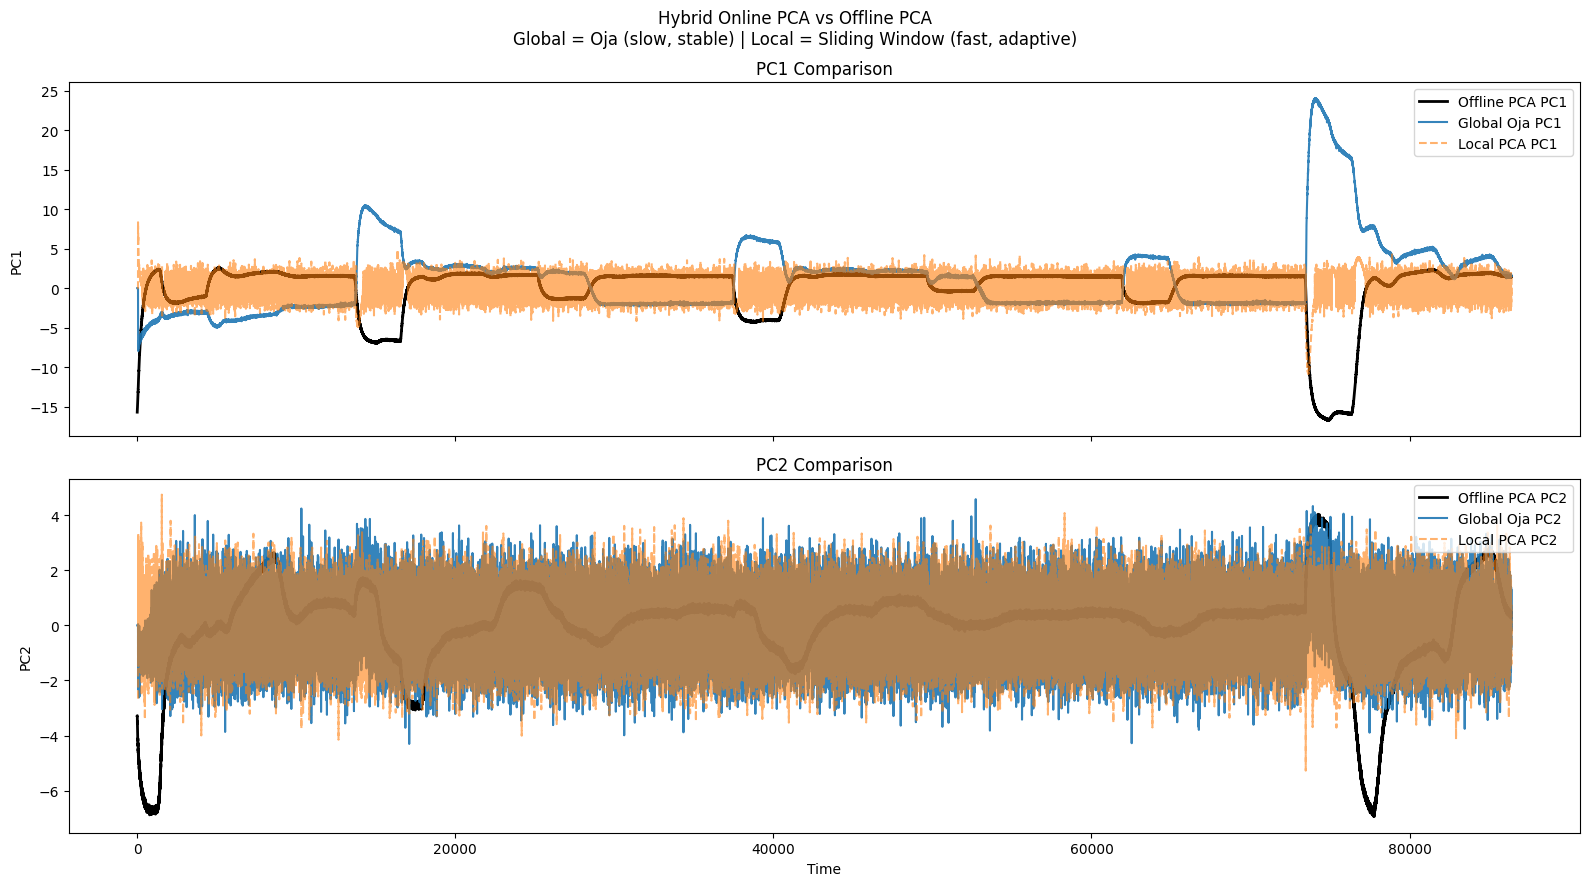

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ============================================================
# CONFIG
# ============================================================
CSV_PATH = r"F:\MultiDimensionalAD\data\long_run_labelled.csv"

DROP_COLS = ["Seconds", "Timestamp_IST", "State", "label"]
SENSOR_TAGS = ("PI", "PT", "TI", "TT")

WARMUP = 50
GLOBAL_K = 2          # global PCA components
LOCAL_K = 2           # local PCA components
WINDOW = 300          # sliding window for local PCA

# ============================================================
# LOAD DATA
# ============================================================
df = pd.read_csv(CSV_PATH)
df = df.drop(columns=[c for c in DROP_COLS if c in df.columns])

sensor_cols = [c for c in df.columns if any(tag in c for tag in SENSOR_TAGS)]
X = df[sensor_cols].values.astype(np.float64)

n_samples, n_features = X.shape
t = np.arange(n_samples)

print(f"Samples: {n_samples}, Sensors: {n_features}")

# ============================================================
# 1️⃣ OFFLINE PCA (BASELINE / GROUND TRUTH)
# ============================================================
scaler_off = StandardScaler()
X_scaled_off = scaler_off.fit_transform(X)

pca_off = PCA(n_components=2)
Z_off = pca_off.fit_transform(X_scaled_off)   # PC1, PC2 baseline

# ============================================================
# 2️⃣ GLOBAL ONLINE PCA — OJA
# ============================================================
class OjaPCA:
    def __init__(self, k=2, lr=0.002):
        self.k = k
        self.lr = lr
        self.W = None

    def partial_fit(self, x):
        if self.W is None:
            self.W = np.random.randn(self.k, x.shape[0])
            self.W /= np.linalg.norm(self.W, axis=1, keepdims=True)

        for i in range(self.k):
            y = self.W[i] @ x
            self.W[i] += self.lr * y * (x - y * self.W[i])
            self.W[i] /= np.linalg.norm(self.W[i])
            x = x - y * self.W[i]  # deflation

    def transform(self, x):
        return np.array([w @ x for w in self.W])

# ============================================================
# 3️⃣ ONLINE PIPELINE (GLOBAL + LOCAL)
# ============================================================
scaler = StandardScaler()
scaler.partial_fit(X[:WARMUP])

oja = OjaPCA(k=GLOBAL_K, lr=0.002)
local_buffer = deque(maxlen=WINDOW)

Z_global = np.zeros((n_samples, GLOBAL_K))
Z_local = np.zeros((n_samples, LOCAL_K))

# warmup
for i in range(WARMUP):
    xs = scaler.transform(X[i:i+1])[0]
    oja.partial_fit(xs)
    local_buffer.append(xs)

# online pass
for i in range(WARMUP, n_samples):
    x = X[i:i+1]
    xs = scaler.transform(x)[0]

    # ---- inference ----
    Z_global[i] = oja.transform(xs)

    if len(local_buffer) >= LOCAL_K + 1:
        Xw = np.array(local_buffer)
        pca_local = PCA(n_components=LOCAL_K)
        Zw = pca_local.fit_transform(Xw)
        Z_local[i] = Zw[-1]
    else:
        Z_local[i] = 0.0

    # ---- update ----
    scaler.partial_fit(x)
    oja.partial_fit(xs)
    local_buffer.append(xs)


# ============================================================

fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)

# ---------------- PC1 ----------------
axes[0].plot(t, Z_off[:, 0], color="black", linewidth=2, label="Offline PCA PC1")
axes[0].plot(t, Z_global[:, 0], label="Global Oja PC1", alpha=0.9)
axes[0].plot(t, Z_local[:, 0], label="Local PCA PC1", linestyle="--", alpha=0.6)

axes[0].set_ylabel("PC1")
axes[0].legend(loc="upper right")
axes[0].set_title("PC1 Comparison")

# ---------------- PC2 ----------------
axes[1].plot(t, Z_off[:, 1], color="black", linewidth=2, label="Offline PCA PC2")
axes[1].plot(t, Z_global[:, 1], label="Global Oja PC2", alpha=0.9)
axes[1].plot(t, Z_local[:, 1], label="Local PCA PC2", linestyle="--", alpha=0.6)

axes[1].set_ylabel("PC2")
axes[1].set_xlabel("Time")
axes[1].legend(loc="upper right")
axes[1].set_title("PC2 Comparison")

plt.suptitle(
    "Hybrid Online PCA vs Offline PCA\n"
    "Global = Oja (slow, stable) | Local = Sliding Window (fast, adaptive)"
)
plt.tight_layout()
plt.show()
